In [72]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import json
import cv2
import os
import math
from datetime import datetime
from typing import Union
from PIL import ImageDraw, ImageFont
import matplotlib.pyplot as plt
from matplotlib import patches, patheffects
from collections import defaultdict, namedtuple
from sklearn.preprocessing import MultiLabelBinarizer
import random
import pandas as pd
import numpy as np

In [3]:
import torch
import torchvision
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader, Dataset

In [4]:
PATH = Path('./VOCdevkit/VOC2007/')
JSON_PATH = Path('./json')

In [5]:
img_size = 300
batch_size = 32

In [6]:
torch.cuda.set_device(2)

In [7]:
torch.cuda.current_device()

2

# EDA

In [8]:
list(PATH.iterdir())

[PosixPath('VOCdevkit/VOC2007/Annotations'),
 PosixPath('VOCdevkit/VOC2007/model-bb1-s1.pth'),
 PosixPath('VOCdevkit/VOC2007/JPEGImages'),
 PosixPath('VOCdevkit/VOC2007/model-bb1-s2.pth'),
 PosixPath('VOCdevkit/VOC2007/model-cls-s1.pth'),
 PosixPath('VOCdevkit/VOC2007/model-cls-s2.pth'),
 PosixPath('VOCdevkit/VOC2007/ImageSets'),
 PosixPath('VOCdevkit/VOC2007/ssd_test_ver.pth'),
 PosixPath('VOCdevkit/VOC2007/SegmentationClass'),
 PosixPath('VOCdevkit/VOC2007/tmp'),
 PosixPath('VOCdevkit/VOC2007/JPEGImages_300_300'),
 PosixPath('VOCdevkit/VOC2007/.ipynb_checkpoints'),
 PosixPath('VOCdevkit/VOC2007/SegmentationObject')]

In [9]:
list(JSON_PATH.iterdir())

[PosixPath('json/pascal_val2007.json'),
 PosixPath('json/pascal_test2007.json'),
 PosixPath('json/pascal_val2012.json'),
 PosixPath('json/pascal_train2007.json'),
 PosixPath('json/pascal_train2012.json')]

## Metadata

In [10]:
annotations = json.load(open(JSON_PATH/'pascal_train2007.json'))

In [11]:
annotations.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [12]:
annotations['categories']

[{'supercategory': 'none', 'id': 1, 'name': 'aeroplane'},
 {'supercategory': 'none', 'id': 2, 'name': 'bicycle'},
 {'supercategory': 'none', 'id': 3, 'name': 'bird'},
 {'supercategory': 'none', 'id': 4, 'name': 'boat'},
 {'supercategory': 'none', 'id': 5, 'name': 'bottle'},
 {'supercategory': 'none', 'id': 6, 'name': 'bus'},
 {'supercategory': 'none', 'id': 7, 'name': 'car'},
 {'supercategory': 'none', 'id': 8, 'name': 'cat'},
 {'supercategory': 'none', 'id': 9, 'name': 'chair'},
 {'supercategory': 'none', 'id': 10, 'name': 'cow'},
 {'supercategory': 'none', 'id': 11, 'name': 'diningtable'},
 {'supercategory': 'none', 'id': 12, 'name': 'dog'},
 {'supercategory': 'none', 'id': 13, 'name': 'horse'},
 {'supercategory': 'none', 'id': 14, 'name': 'motorbike'},
 {'supercategory': 'none', 'id': 15, 'name': 'person'},
 {'supercategory': 'none', 'id': 16, 'name': 'pottedplant'},
 {'supercategory': 'none', 'id': 17, 'name': 'sheep'},
 {'supercategory': 'none', 'id': 18, 'name': 'sofa'},
 {'super

In [13]:
annotations['annotations'][0]

{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]],
 'area': 34104,
 'iscrowd': 0,
 'image_id': 12,
 'bbox': [155, 96, 196, 174],
 'category_id': 7,
 'id': 1,
 'ignore': 0}

In [14]:
annotations['categories'][0]

{'supercategory': 'none', 'id': 1, 'name': 'aeroplane'}

In [15]:
categories = {d['id']:d['name'] for d in annotations['categories']}
categories

{1: 'aeroplane',
 2: 'bicycle',
 3: 'bird',
 4: 'boat',
 5: 'bottle',
 6: 'bus',
 7: 'car',
 8: 'cat',
 9: 'chair',
 10: 'cow',
 11: 'diningtable',
 12: 'dog',
 13: 'horse',
 14: 'motorbike',
 15: 'person',
 16: 'pottedplant',
 17: 'sheep',
 18: 'sofa',
 19: 'train',
 20: 'tvmonitor'}

## Images

In [16]:
IMG_PATH = PATH/'JPEGImages'
list(IMG_PATH.iterdir())[:5]

[PosixPath('VOCdevkit/VOC2007/JPEGImages/007622.jpg'),
 PosixPath('VOCdevkit/VOC2007/JPEGImages/000450.jpg'),
 PosixPath('VOCdevkit/VOC2007/JPEGImages/002505.jpg'),
 PosixPath('VOCdevkit/VOC2007/JPEGImages/003271.jpg'),
 PosixPath('VOCdevkit/VOC2007/JPEGImages/006858.jpg')]

In [17]:
annotations['images'][:5]

[{'file_name': '000012.jpg', 'height': 333, 'width': 500, 'id': 12},
 {'file_name': '000017.jpg', 'height': 364, 'width': 480, 'id': 17},
 {'file_name': '000023.jpg', 'height': 500, 'width': 334, 'id': 23},
 {'file_name': '000026.jpg', 'height': 333, 'width': 500, 'id': 26},
 {'file_name': '000032.jpg', 'height': 281, 'width': 500, 'id': 32}]

In [18]:
def bounding_box(bb):
    """switch x/y coords to be consistent with numpy, convert height/width into top-left/bottom-right"""
    return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])

# make dictionary {img_id:[(cat_id, bbox), (cat_id, bbox), ...]}
def make_anno_dict(anno_json):
    anno_dict = defaultdict(list)
    for anno in anno_json['annotations']:
        if not anno['ignore']:
    #         bb = bounding_box(anno['bbox'])
            bb = np.array(anno['bbox'])  # matplotlib accepts VOC format bounding box, so no need to convert
            anno_dict[anno['image_id']].append(
                (anno['category_id'], bb))
    return anno_dict

# open image
def load_image(img_path):
    img = cv2.imread(str(img_path)).astype(np.float32)/255
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img_rgb

def show_img(im, figsize=None, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)
    return ax


def draw_outline(plt_object, lw):
    plt_object.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])


def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(
        b[:2], *b[-2:], fill=False, edgecolor='#00ff00', lw=2))
    draw_outline(patch, 4)


def draw_text(ax, xy, txt, font_sz=14):
    text = ax.text(*xy, txt,
                   verticalalignment='top', color='#00ff00', fontsize=font_sz, weight='bold')
    draw_outline(text, 1)

def show_by_index(idx:int, annotations:dict):
    img_path = str(IMG_PATH/f'{idx:06d}.jpg')
    img = load_image(img_path)
    
    if idx in annotations.keys():
        print(img_path)
        ax = show_img(img, figsize=(12, 12))
        for item in annotations[idx]:
            b = item[1]
            print(f'Bounding box:\nY: {b[1]}\nX: {b[0]}\nHeight: {b[3]}\nWidth: {b[2]}')
            draw_rect(ax, b)
            draw_text(ax, b[:2], categories[item[0]])

In [19]:
train_anno = make_anno_dict(annotations)

VOCdevkit/VOC2007/JPEGImages/005984.jpg
Bounding box:
Y: 199
X: 92
Height: 170
Width: 203
Bounding box:
Y: 214
X: 279
Height: 116
Width: 185
Bounding box:
Y: 57
X: 59
Height: 317
Width: 386


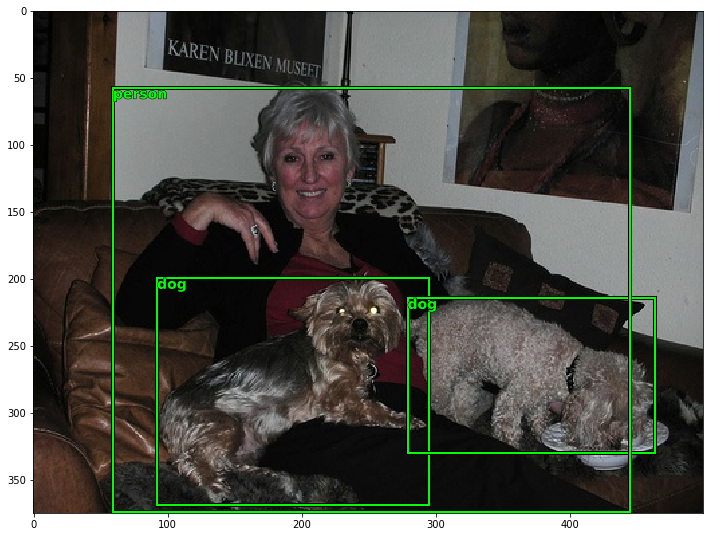

In [20]:
img_ids = list(train_anno.keys())
idx = random.sample(img_ids, 1)[0]
show_by_index(idx, train_anno)

# Image Augmentation

In [21]:
# When using pre-trained networks you should normalized your images in the same way the
# authors of the model did.
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

def denormalize(im):
    """Denormalizes images."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im * imagenet_stats[1]) + imagenet_stats[0]

## For images

In [22]:
def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

def random_crop(x, target_r, target_c):
    """ Returns a random crop"""
    r,c,*_ = x.shape
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(rand_r*(r - target_r)).astype(int)
    start_c = np.floor(rand_c*(c - target_c)).astype(int)
    return crop(x, start_r, start_c, target_r, target_c)

def rotate_cv(im, deg, bbox=False, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if bbox:
        return cv2.warpAffine(im, M, (c,r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im, M, (c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

## For bounding boxes  

width-height format => bounding-box format => pixel format => resized pixel format => bounding-box format => width-height format

In [23]:
def make_bb_px(y, x):
    """Makes an image of size x retangular bounding box"""
    r, c, *_ = x.shape
    Y = np.zeros((r, c))
#     print(y)
    y = hw_bb(y).astype(np.int)
    Y[y[0]:y[2], y[1]:y[3]] = 1.
    return Y


def to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0: return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)


def hw_bb(bb): 
    """Transform from width-height format to bounding box format.
    
    width-height: [X, Y, width, height]
    bounding-box: [Y, X, left-bottom, right-top]
    """
    return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])


def bb_hw(bb): 
    """Transform from bounding box format to width-height format.
    
    width-height: [X, Y, width, height]
    bounding-box: [Y, X, left-bottom, right-top]
    """
    return np.array([bb[1], bb[0], bb[3]-bb[1]+1, bb[2]-bb[0]+1])

# Modelling

In [24]:
import os
os.getcwd()

'/data/xhan/project/Kaggle/pascal'

In [168]:
from src.transform import __boxtools__
from src.ssd import ssd_prior

In [26]:
categories_bb = categories.copy()
categories_bb[0] = 'background'

In [27]:
categories_bb.values()

dict_values(['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor', 'background'])

In [28]:
categories_bb

{1: 'aeroplane',
 2: 'bicycle',
 3: 'bird',
 4: 'boat',
 5: 'bottle',
 6: 'bus',
 7: 'car',
 8: 'cat',
 9: 'chair',
 10: 'cow',
 11: 'diningtable',
 12: 'dog',
 13: 'horse',
 14: 'motorbike',
 15: 'person',
 16: 'pottedplant',
 17: 'sheep',
 18: 'sofa',
 19: 'train',
 20: 'tvmonitor',
 0: 'background'}

## Load data

In [29]:
train_bbox_multi_df = pd.read_csv(PATH/'tmp/train_bbox_multi.csv')
val_bbox_multi_df = pd.read_csv(PATH/'tmp/val_bbox_multi.csv')

In [30]:
train_bbox_multi_df.head(5)

,fn,label,bbox,bbox_300
0,../../VOCdevkit/VOC2007/JPEGImages_300_300/000...,7,155 96 196 174,93 86 117 157
1,../../VOCdevkit/VOC2007/JPEGImages_300_300/000...,15 13,184 61 95 138 89 77 314 259,115 50 59 114 55 63 197 214
2,../../VOCdevkit/VOC2007/JPEGImages_300_300/000...,2 2 15 15 15,8 229 237 271 229 219 105 281 1 0 116 369 2 1 ...,7 137 213 163 205 131 95 169 0 0 105 221 1 0 2...
3,../../VOCdevkit/VOC2007/JPEGImages_300_300/000...,7,89 124 248 88,53 111 149 80
4,../../VOCdevkit/VOC2007/JPEGImages_300_300/000...,1 1 15 15,103 77 272 106 132 87 65 36 194 179 19 50 25 1...,62 82 163 113 79 92 39 39 116 191 11 53 15 200...


In [31]:
IMG_PATH = PATH/'JPEGImages_300_300'

In [142]:
class multiBboxDataset(Dataset):
    def __init__(self, root, dataset, transform=False, target_transform=None, sz=img_size, is_test=False):
        self.root = Path(root)
        self.dataset = self.make_anno_dict(dataset)
        self.sz = img_size
        self.transform = transform
        self.target_transform = target_transform
        self.is_test = is_test
        self.classes = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 
                        'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 
                        'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor', 'background']
        self.class_dict = {i:class_name for i, class_name in enumerate(self.classes)}

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, i):
        image = self.get_image(i)
        labels = self.dataset[i]['labels']
        boxes = self.dataset[i]['boxes']
        boxes = torch.from_numpy(np.array(boxes)).float()#.cuda(non_blocking=True)
        labels = torch.from_numpy(np.array(labels)).float()#.cuda(non_blocking=True)
        boxes = __boxtools__.hw_bb(boxes)
        boxes, _ = __boxtools__.to_percent_coords(image.shape[:2], boxes)
        if self.target_transform:
            locations, labels = self.target_transform(boxes, labels)
        image = normalize(image)
        return image.transpose(2, 0, 1), labels, locations

    def get_image(self, index):
        image_path = str(self.root/self.dataset[index]['img_name'])
        image = load_image(image_path)
        return image
    
    def make_anno_dict(self, df):
        out = []
        for row in df.values:
            anno_dict = dict()
            anno_dict['img_name'] = row[0].split('/')[-1]
            anno_dict['labels'] = np.array([int(x) for x in row[1].split()])
            bbs = row[3].split()
            anno_dict['boxes'] = np.array([bbs[i*4:i*4+4] for i in range(int(len(bbs)/4))], dtype=np.float)
            out.append(anno_dict)
        return out

In [143]:
SSDBoxSizes = namedtuple('SSDBoxSizes', ['min', 'max'])
SSDSpec = namedtuple('SSDSpec', ['feature_map_size', 'shrinkage', 'box_sizes', 'aspect_ratios'])

specs = [
        SSDSpec(38, 8, SSDBoxSizes(30, 60), [2]),
        SSDSpec(19, 16, SSDBoxSizes(60, 111), [2, 3]),
        SSDSpec(10, 32, SSDBoxSizes(111, 162), [2, 3]),
        SSDSpec(5, 64, SSDBoxSizes(162, 213), [2, 3]),
        SSDSpec(3, 100, SSDBoxSizes(213, 264), [2]),
        SSDSpec(1, 300, SSDBoxSizes(264, 315), [2])
        ]

In [169]:
center_variance = 0.1
size_variance = 0.2
iou_threshold = 0.5
priors = __boxtools__.generate_ssd_priors(specs, image_size=img_size, clip=True)
priors = torch.from_numpy(priors).float()#.cuda(non_blocking=True)
target_transform = ssd_prior.MatchPrior(priors, center_variance,
                                        size_variance, iou_threshold)

In [170]:
voc_multibb_train = multiBboxDataset(IMG_PATH, train_bbox_multi_df, transform=True,
                                     target_transform=target_transform, 
                                     sz=img_size, is_test=False)

voc_multibb_valid = multiBboxDataset(IMG_PATH, val_bbox_multi_df, transform=True, 
                                     target_transform=target_transform,
                                     sz=img_size, is_test=True)

In [173]:
train_dl = DataLoader(voc_multibb_train, batch_size=batch_size, shuffle=True, num_workers=6, pin_memory=False)
val_dl = DataLoader(voc_multibb_valid, batch_size=batch_size, num_workers=6, pin_memory=False)

In [174]:
X, y_label, y_bb = next(iter(train_dl))

In [175]:
X.shape, y_label.shape, y_bb.shape

(torch.Size([32, 3, 300, 300]),
 torch.Size([32, 8732]),
 torch.Size([32, 8732, 4]))

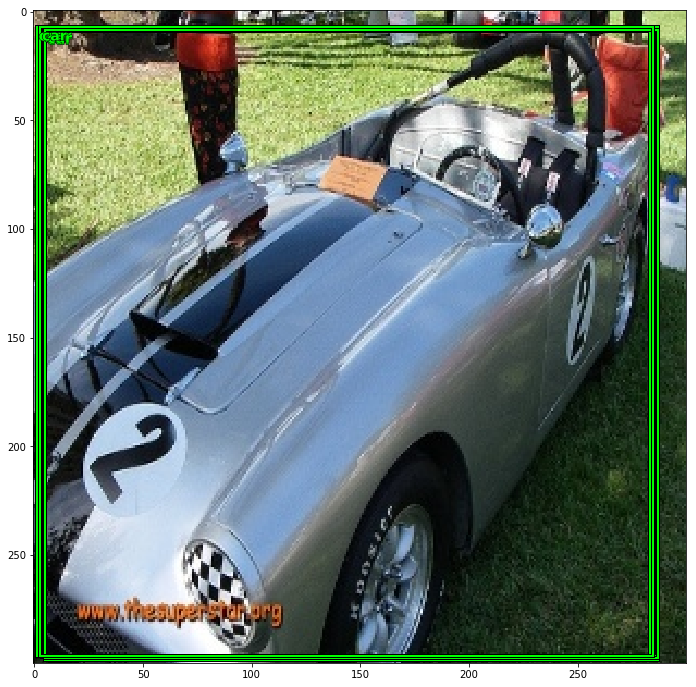

In [192]:
# check augmentation of bounding box
idx = random.randrange(32)
# print(idx)
img = denormalize(X[idx].permute(1, 2, 0).numpy())
ax = show_img(img, figsize=(12, 12))
i_s = np.where(y_label.numpy()[idx] != 0)[0]
# print(i_s)
for i in i_s:
    # center form real box
    bb_real = __boxtools__.convert_locations_to_boxes(y_bb[idx][i].unsqueeze(0).float(), priors,
                                                      center_variance, size_variance)
    box, _ = __boxtools__.to_absolute_coords(img.shape[:2], 
                                             boxes=bb_real[i].reshape(1, -1),
                                             labels=None)
    box = __boxtools__.center_hw(box.squeeze())
#     print(box)
#     print(y_label[idx][i].item())
    draw_rect(ax, box)
    text = categories_bb[y_label[idx][i].item()]
    draw_text(ax, box[:2]+1, text)

## Model

In [218]:
# check vgg16 structure
models.vgg16().features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(

### TODO: refactor the model structure

For now we flatten the structure for better understanding.

In [193]:
class SSDNet(nn.Module):
    def __init__(self, num_classes=21, im_shape=(300, 300), is_test=False):
        super(SSDNet, self).__init__()
        self.num_classes = num_classes
        self.im_shape = im_shape
        self.is_test = is_test
        # 1: vgg16 (0-22), 512x38x38
        vgg16 = models.vgg16(pretrained=True)
        for param in vgg16.parameters():
            param.requires_grad = False
        layers = vgg16.features[:23] # all the way to Conv4-3
        self.top_model = nn.Sequential(*layers)
        self.bn1 = nn.BatchNorm2d(512)
        self.cls1_conv = nn.Conv2d(512, 4*self.num_classes, kernel_size=2, stride=1, padding=1)
        self.reg1_conv = nn.Conv2d(512, 4*4, kernel_size=2, stride=1, padding=1)
        
        # 2: vgg16 (23-29), 1024x19x19
        layers_2 = vgg16.features[23:30]
        self.extra2 = nn.Sequential(
            *layers_2, # Conv5-1, 5-2, 5-3
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(1024, 1024, kernel_size=1, stride=1),
            nn.BatchNorm2d(1024),
            nn.ReLU()
        )
#         self.bn2 = nn.BatchNorm2d(1024)
        self.cls2_conv = nn.Conv2d(1024, 6*self.num_classes, kernel_size=2, stride=1, padding=1)
        self.reg2_conv = nn.Conv2d(1024, 6*4, kernel_size=2, stride=1, padding=1)
        
        # 3: 512x10x10
        self.extra3 = nn.Sequential(
            nn.Conv2d(1024, 256, kernel_size=1, stride=1),
            nn.BatchNorm2d(256), 
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
#         self.bn3 = nn.BatchNorm2d(512)
        self.cls3_conv = nn.Conv2d(512, 6*self.num_classes, kernel_size=2, stride=1, padding=1)
        self.reg3_conv = nn.Conv2d(512, 6*4, kernel_size=2, stride=1, padding=1)
        
        # 4: 256x5x5
        self.extra4 = nn.Sequential(
            nn.Conv2d(512, 128, kernel_size=1, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
#         self.bn4 = nn.BatchNorm2d(256)
        self.cls4_conv = nn.Conv2d(256, 6*self.num_classes, kernel_size=3, stride=1, padding=1)
        self.reg4_conv = nn.Conv2d(256, 6*4, kernel_size=3, stride=1, padding=1)
        
        # 5: 256x3x3
        self.extra5 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=1, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
#         self.bn5 = nn.BatchNorm2d(256)
        self.cls5_conv = nn.Conv2d(256, 4*self.num_classes, kernel_size=3, stride=1, padding=1)
        self.reg5_conv = nn.Conv2d(256, 4*4, kernel_size=3, stride=1, padding=1)
        
        # 6: 256x1x1
        self.extra6 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=1, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
#         self.bn6 = nn.BatchNorm2d(256)
        self.cls6_conv = nn.Conv2d(256, 4*self.num_classes, kernel_size=3, stride=1, padding=1)
        self.reg6_conv = nn.Conv2d(256, 4*4, kernel_size=3, stride=1, padding=1)
    
    def forward(self, X):
        confidences = []
        locations = []
        X = self.top_model(X)
        # 1
        X1 = self.bn1(X)
#         X1 = nn.Dropout2d(0.1)(X1_o)
        X1_cls = self.cls1_conv(X1)
        X1_reg = self.reg1_conv(X1)
        X1_conf = X1_cls.permute(0, 2, 3, 1).contiguous()
        X1_conf = X1_conf.view(X1_conf.size(0), -1, self.num_classes)
        X1_location = X1_reg.permute(0, 2, 3, 1).contiguous()
        X1_location = X1_location.view(X1_location.size(0), -1, 4)
        confidences.append(X1_conf)
        locations.append(X1_location)
        # 2
        X2 = self.extra2(X1)
#         X2 = nn.Dropout2d(0.1)(X2_o)
        X2_cls = self.cls2_conv(X2)
        X2_reg = self.reg2_conv(X2)
        X2_conf = X2_cls.permute(0, 2, 3, 1).contiguous()
        X2_conf = X2_conf.view(X2_conf.size(0), -1, self.num_classes)
        X2_location = X2_reg.permute(0, 2, 3, 1).contiguous()
        X2_location = X2_location.view(X2_location.size(0), -1, 4)
        confidences.append(X2_conf)
        locations.append(X2_location)
        # 3
        X3 = self.extra3(X2)
#         X3 = nn.Dropout2d(0.1)(X3_o)
        X3_cls = self.cls3_conv(X3)
        X3_reg = self.reg3_conv(X3)
        X3_conf = X3_cls.permute(0, 2, 3, 1).contiguous()
        X3_conf = X3_conf.view(X1_conf.size(0), -1, self.num_classes)
        X3_location = X3_reg.permute(0, 2, 3, 1).contiguous()
        X3_location = X3_location.view(X3_location.size(0), -1, 4)
        confidences.append(X3_conf)
        locations.append(X3_location)
        # 4
        X4 = self.extra4(X3)
#         X4 = nn.Dropout2d(0.1)(X4_o)
        X4_cls = self.cls4_conv(X4)
        X4_reg = self.reg4_conv(X4)
        X4_conf = X4_cls.permute(0, 2, 3, 1).contiguous()
        X4_conf = X4_conf.view(X4_conf.size(0), -1, self.num_classes)
        X4_location = X4_reg.permute(0, 2, 3, 1).contiguous()
        X4_location = X4_location.view(X4_location.size(0), -1, 4)
        confidences.append(X4_conf)
        locations.append(X4_location)
        # 5
        X5 = self.extra5(X4)
#         X5 = nn.Dropout2d(0.1)(X5_o)
        X5_cls = self.cls5_conv(X5)
        X5_reg = self.reg5_conv(X5)
        X5_conf = X5_cls.permute(0, 2, 3, 1).contiguous()
        X5_conf = X5_conf.view(X5_conf.size(0), -1, self.num_classes)
        X5_location = X5_reg.permute(0, 2, 3, 1).contiguous()
        X5_location = X5_location.view(X5_location.size(0), -1, 4)
        confidences.append(X5_conf)
        locations.append(X5_location)
        # 6
        X6 = self.extra6(X5)
#         X6 = nn.Dropout2d(0.1)(X6_o)
        X6_cls = self.cls6_conv(X6)
        X6_reg = self.reg6_conv(X6)
        X6_conf = X6_cls.permute(0, 2, 3, 1).contiguous()
        X6_conf = X6_conf.view(X6_conf.size(0), -1, self.num_classes)
        X6_location = X6_reg.permute(0, 2, 3, 1).contiguous()
        X6_location = X6_location.view(X6_location.size(0), -1, 4)
        confidences.append(X6_conf)
        locations.append(X6_location)
        
        confidences = torch.cat(confidences, 1)
        locations = torch.cat(locations, 1)
        
#         if self.is_test:
#             bb_real = __boxtools__.convert_locations_to_boxes(locations.double(), priors,
#                                                               center_variance, size_variance)
#             boxes, _ = __boxtools__.to_absolute_coords(self.im_shape, 
#                                                        bb_real.reshape(1, -1),
#                                                        labels=None)
#             boxes = __boxtools__.bb_hw(boxes.squeeze())
#             confidences = F.softmax(confidences.to(cpu_device), dim=-1)
#             return confidences, boxes
    
        return confidences, locations
    

In [194]:
def multibox_loss(confidence, predicted_locations, labels, gt_locations, priors,
                  num_classes=21, neg_pos_ratio=3):
    """Calculate multibox losses:
            classification - cross entropy
            bounding boxes - smooth L1 loss
    
    Args:
        confidence (batch_size, num_priors, num_classes): class predictions
        predicted_locations (batch_size, num_priors, 4): predicted locations
        gt_locations (batch_size, num_priors, 4): ground truth locations
        labels (batch_size, num_priors): real labels of all the priors
        priors (batch_size, num_priors, 4): real boxes corresponding all the priors
        num_classes: total number of classes
        neg_pos_ratio: the ratio between the negative examples and positive examples
    """
    with torch.no_grad():
        # derived from cross_entropy=sum(log(p))
        loss = -F.log_softmax(confidence, dim=2)[:, :, 0]
        mask = __boxtools__.hard_negative_mining(loss, labels, neg_pos_ratio)

    confidence = confidence[mask, :]
    classification_loss = F.cross_entropy(confidence.reshape(-1, num_classes), labels[mask])
    pos_mask = labels > 0
    predicted_locations = predicted_locations[pos_mask, :].reshape(-1, 4)
    gt_locations = gt_locations[pos_mask, :].reshape(-1, 4)
    smooth_l1_loss = F.smooth_l1_loss(predicted_locations, gt_locations)
    num_pos = gt_locations.size(0)
    torch.cuda.empty_cache()
    
    return smooth_l1_loss, classification_loss

In [195]:
def val_metrics_multibox(model, valid_dl, priors):
    model.eval()
    total = len(valid_dl)
    sum_l1_loss = 0
    sum_ce_loss = 0
    sum_loss = 0
    
    for i, (x, y_label, y_loc) in enumerate(valid_dl):
#         batch = y_label.shape[0]
        x = x.cuda().float()
        y_label = y_label.cuda().long()
        y_loc = y_loc.cuda().float()
        
        with torch.no_grad():
            confidences, locations = model(x)
            l1_loss, ce_loss = multibox_loss(confidences, locations, y_label, y_loc, priors,
                                             num_classes=21, neg_pos_ratio=3)
            loss = l1_loss + ce_loss
        
        sum_loss += loss.item()
        sum_l1_loss += l1_loss.item()
        sum_ce_loss += ce_loss.item()
        
        torch.cuda.empty_cache()
    print(f"Valid L1 loss {(sum_l1_loss/total):.3f} | CE loss: {sum_ce_loss/total:.3f} | Total Loss: {sum_loss/total}")

## Learning Rate Finder

In [196]:
def get_optimizer(model, lr=1e-2, mom=0.9):
    params = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch.optim.SGD(params, lr=lr, momentum=mom)
    return optim

In [197]:
def save_model(m, p): 
    torch.save(m.state_dict(), p)
    
def load_model(m, p):
    checkpoint = torch.load(p)
    m.load_state_dict(checkpoint)
    del checkpoint
    torch.cuda.empty_cache()

In [198]:
def even_mults(start: float, stop: float, n: int)->np.ndarray:
    """Build log-stepped array from `start` to `stop` in `n` steps evenly."""
    mult = stop/start
    step = mult**(1/(n-1))
    return np.array([start*(step**i) for i in range(n)])


def lr_range(lr: Union[float, slice], n)->np.ndarray:
    """Build differential learning rates from `lr`."""
    if not isinstance(lr, slice):
        return lr
    if lr.start:
        lrs = even_mults(lr.start, lr.stop, n)
    else:
        lrs = [lr.stop/10] * (n-1) + [lr.stop]
    return np.array(lrs)

In [199]:
def get_triangular_mom(mom_low=0.85, mom_high=0.95, iterations=50):
    iter1 = int(0.45 * iterations)
    iter2 = int(1.0 * iter1)
    iter3 = iterations - iter1 - iter2

    delta_1 = (mom_high - mom_low) / iter1
    delta_2 = (mom_high - mom_low) / (iter2 - 1)
    moms1 = [mom_high - i * delta_1 for i in range(iter1)]
    moms2 = [mom_low + i * delta_2 for i in range(0, iter2)]
    moms3 = [moms2[-1] for i in range(1, iter3 + 1)]

    return moms1 + moms2 + moms3

In [200]:
def get_triangular_lr(lr_optimal, div_factor, iterations):
    iter1 = int(0.45 * iterations)
    iter2 = int(1.0 * iter1)
    iter3 = iterations - iter1 - iter2

    lr_low = lr_optimal/div_factor
    lr_high = lr_optimal

    delta_1 = (lr_high - lr_low) / iter1
    delta_2 = (lr_high - lr_low) / (iter2 - 1)
    lrs1 = [lr_low + i * delta_1 for i in range(iter1)]
    lrs2 = [lr_high - i * delta_2 for i in range(0, iter2)]
    delta_3 = (lrs2[-1] - lr_low / 100) / iter3
    lrs3 = [lrs2[-1] - i * delta_3 for i in range(1, iter3 + 1)]

    return lrs1 + lrs2 + lrs3

In [201]:
def set_trainable_attr(m, b=True):
    for p in m.parameters(): 
        p.requires_grad = b

def unfreeze(model, l):
    top_model = model.top_model
    set_trainable_attr(top_model[l])

In [202]:
def LR_range_finder_multibox(model, train_dl, priors, lr_low=1e-6, lr_high=1, epochs=4):
    losses = []
    p = PATH/"model_tmp.pth"
    save_model(model, str(p))
    iterations = epochs * len(train_dl)
    lrs = lr_range(slice(lr_low, lr_high), iterations)
    model.train()
    ind = 0
    for i in range(epochs):
        for x, y_label, y_loc in train_dl:
            optim = get_optimizer(model, lr=lrs[ind])
            x = x.cuda().float()
            y_label = y_label.cuda().long()
            y_loc = y_loc.cuda().float()
            confidences, locations = model(x)
            l1_loss, ce_loss = multibox_loss(confidences, locations, y_label, y_loc, priors,
                                             num_classes=21, neg_pos_ratio=3)
            loss = l1_loss + ce_loss
            optim.zero_grad()
            loss.backward()
            optim.step()
            losses.append(loss.item())
            ind +=1
    load_model(model, str(p))
    torch.cuda.empty_cache()
    return lrs, losses

In [203]:
torch.cuda.empty_cache()

In [509]:
model = SSDNet().cuda()

In [510]:
lrs, losses = LR_range_finder_multibox(model, train_dl, priors, lr_low=1e-6, lr_high=1, epochs=2)

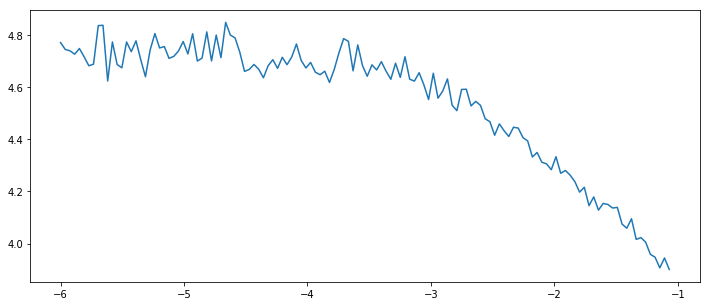

In [519]:
plt.figure(figsize=(12, 5))
plt.plot([np.log10(l) for l in lrs][:130], losses[:130])
plt.show()

## Training

In [204]:
def one_cycle_multibox(model, train_dl, valid_dl, priors, lr_optimal=1e-4, div_factor=25, epochs=4):
    iterations = epochs * len(train_dl)
    lrs = get_triangular_lr(lr_optimal, div_factor, iterations)
    moms = get_triangular_mom(0.85, 0.95, iterations)
    
    idx = 0
    
    model.train()
    
    for epoch in range(epochs):
        running_loss = 0.0
        running_l1_loss = 0.0
        running_ce_loss = 0.0
        total = len(train_dl)
        for i, (x, y_label, y_loc) in enumerate(train_dl):
            optim = get_optimizer(model, lr=lrs[idx], mom=moms[idx])
            x = x.cuda().float()
            y_label = y_label.cuda().long()
            y_loc = y_loc.cuda().float()
            confidences, locations = model(x)
            l1_loss, ce_loss = multibox_loss(confidences, locations, y_label, y_loc, priors,
                                             num_classes=21, neg_pos_ratio=3)
            loss = l1_loss + ce_loss/5 # balance the two losses
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            idx += 1
            running_loss += loss.item()
            running_l1_loss += l1_loss.item()
            running_ce_loss += ce_loss.item()
    
        avg_loss = running_loss / total
        avg_reg_loss = running_l1_loss / total
        avg_clf_loss = running_ce_loss / total
        print(
            f"Epoch: {epoch+1} | " +
            f"Avg Training Loss: {avg_loss:.4f} | " +
            f"Avg Regression Loss {avg_reg_loss:.4f} | " +
            f"Avg Classification Loss: {avg_clf_loss:.4f}"
        )
        torch.cuda.empty_cache()
        val_metrics_multibox(model, valid_dl, priors)

In [205]:
def training_loop_multibox(model, train_dl, valid_dl, priors, steps=3, lr_optimal=1e-2, div_factor=25, epochs=4):
    for i in range(steps):
        start = datetime.now() 
        one_cycle_multibox(model, train_dl, valid_dl, priors, lr_optimal, div_factor, epochs)
        end = datetime.now()
        t = 'Time elapsed {}'.format(end - start)
        print("----End of step", t)

In [63]:
torch.cuda.empty_cache()

In [206]:
model = SSDNet().cuda()

In [55]:
training_loop_multibox(model, train_dl, val_dl, priors, steps=2, lr_optimal=1e-2, div_factor=25, epochs=5)

Epoch: 1 | Avg Training Loss: 1.5538 | Avg Regression Loss 0.7812 | Avg Classification Loss: 3.8628
Valid L1 loss 0.769 | CE loss: 3.704 | Total Loss: 4.473251360881178
Epoch: 2 | Avg Training Loss: 1.4660 | Avg Regression Loss 0.7489 | Avg Classification Loss: 3.5853
Valid L1 loss 0.740 | CE loss: 3.493 | Total Loss: 4.2326087830941885
Epoch: 3 | Avg Training Loss: 1.4013 | Avg Regression Loss 0.7152 | Avg Classification Loss: 3.4307
Valid L1 loss 0.716 | CE loss: 3.383 | Total Loss: 4.0990318829500225
Epoch: 4 | Avg Training Loss: 1.3591 | Avg Regression Loss 0.6884 | Avg Classification Loss: 3.3534
Valid L1 loss 0.703 | CE loss: 3.337 | Total Loss: 4.0404774901233145
Epoch: 5 | Avg Training Loss: 1.3394 | Avg Regression Loss 0.6739 | Avg Classification Loss: 3.3274
Valid L1 loss 0.701 | CE loss: 3.330 | Total Loss: 4.0309138901626005
----End of step Time elapsed 0:51:35.617014
Epoch: 1 | Avg Training Loss: 1.3646 | Avg Regression Loss 0.6978 | Avg Classification Loss: 3.3339
Valid L

In [400]:
training_loop_multibox(model, train_dl, val_dl, priors, steps=2, lr_optimal=1e-2, div_factor=25, epochs=5)

Epoch: 1 | Avg Training Loss: 1.1882 | Avg Regression Loss 0.5896 | Avg Classification Loss: 2.9932
Valid L1 loss 0.645 | CE loss: 2.992 | Total Loss: 3.6368910843812965
Epoch: 2 | Avg Training Loss: 1.1298 | Avg Regression Loss 0.5417 | Avg Classification Loss: 2.9403
Valid L1 loss 0.609 | CE loss: 2.936 | Total Loss: 3.5453293715851215
Epoch: 3 | Avg Training Loss: 1.0981 | Avg Regression Loss 0.5183 | Avg Classification Loss: 2.8990
Valid L1 loss 0.604 | CE loss: 2.900 | Total Loss: 3.504096477846556
Epoch: 4 | Avg Training Loss: 1.0720 | Avg Regression Loss 0.4974 | Avg Classification Loss: 2.8727
Valid L1 loss 0.592 | CE loss: 2.884 | Total Loss: 3.4765476003477844
Epoch: 5 | Avg Training Loss: 1.0634 | Avg Regression Loss 0.4911 | Avg Classification Loss: 2.8613
Valid L1 loss 0.591 | CE loss: 2.881 | Total Loss: 3.472070696987683
----End of step Time elapsed 0:54:03.241327
Epoch: 1 | Avg Training Loss: 1.1470 | Avg Regression Loss 0.5616 | Avg Classification Loss: 2.9272
Valid L1

In [251]:
training_loop_multibox(model, train_dl, val_dl, priors, steps=2, lr_optimal=1e-2, div_factor=25, epochs=5)

Epoch: 1 | Avg Training Loss: 1.1152 | Avg Regression Loss 0.5401 | Avg Classification Loss: 2.8756
Valid L1 loss 0.620 | CE loss: 2.878 | Total Loss: 3.4984258518943303
Epoch: 2 | Avg Training Loss: 1.0400 | Avg Regression Loss 0.4799 | Avg Classification Loss: 2.8003
Valid L1 loss 0.585 | CE loss: 2.802 | Total Loss: 3.3868985266625127
Epoch: 3 | Avg Training Loss: 1.0120 | Avg Regression Loss 0.4594 | Avg Classification Loss: 2.7629
Valid L1 loss 0.579 | CE loss: 2.772 | Total Loss: 3.3511811509917053
Epoch: 4 | Avg Training Loss: 0.9915 | Avg Regression Loss 0.4438 | Avg Classification Loss: 2.7384
Valid L1 loss 0.575 | CE loss: 2.758 | Total Loss: 3.332825075221967
Epoch: 5 | Avg Training Loss: 0.9829 | Avg Regression Loss 0.4363 | Avg Classification Loss: 2.7333
Valid L1 loss 0.570 | CE loss: 2.756 | Total Loss: 3.326235692712325
----End of step Time elapsed 0:53:16.839385
Epoch: 1 | Avg Training Loss: 1.0853 | Avg Regression Loss 0.5184 | Avg Classification Loss: 2.8345
Valid L1

In [153]:
training_loop_multibox(model, train_dl, val_dl, priors, steps=1, lr_optimal=1e-2, div_factor=25, epochs=10)

Epoch: 1 | Avg Training Loss: 1.0615 | Avg Regression Loss 0.5012 | Avg Classification Loss: 2.8017
Valid L1 loss 0.607 | CE loss: 2.807 | Total Loss: 3.414875947976414
Epoch: 2 | Avg Training Loss: 0.9779 | Avg Regression Loss 0.4350 | Avg Classification Loss: 2.7145
Valid L1 loss 0.570 | CE loss: 2.717 | Total Loss: 3.287758145151259
Epoch: 3 | Avg Training Loss: 0.9530 | Avg Regression Loss 0.4179 | Avg Classification Loss: 2.6754
Valid L1 loss 0.574 | CE loss: 2.695 | Total Loss: 3.269005594374258
Epoch: 4 | Avg Training Loss: 0.9420 | Avg Regression Loss 0.4124 | Avg Classification Loss: 2.6483
Valid L1 loss 0.569 | CE loss: 2.663 | Total Loss: 3.232623136496242
Epoch: 5 | Avg Training Loss: 0.9328 | Avg Regression Loss 0.4082 | Avg Classification Loss: 2.6226
Valid L1 loss 0.565 | CE loss: 2.634 | Total Loss: 3.1993799511390395
Epoch: 6 | Avg Training Loss: 0.9091 | Avg Regression Loss 0.3908 | Avg Classification Loss: 2.5915
Valid L1 loss 0.563 | CE loss: 2.607 | Total Loss: 3.1

In [155]:
from src.utils import __utils__

p = PATH/'ssd_test_ver.pth'
__utils__.save_model(model, p)

# Prediction

In [207]:
def predict(im_shape, locations, confidences, priors, top_k=-1, score_threshold=.3,
            prob_threshold=.5, iou_threshold=.5, candidate_size=200, sigma=.5, nms_type='hard'):
    # this version of hard nm prediction is slower on GPU, so we move data to CPU.
    cpu_device = torch.device("cpu")
    locations = locations.to(cpu_device)
    confidences = confidences.to(cpu_device)
    
    # convert
    bb_real = __boxtools__.convert_locations_to_boxes(__boxtools__.bb_center(locations),
                                                      priors,
                                                      center_variance, size_variance)
    boxes, _ = __boxtools__.to_absolute_coords(im_shape, 
                                               boxes=bb_real,
                                               labels=None)
    boxes = __boxtools__.center_hw(boxes.squeeze()).float()
    confidences = F.softmax(confidences, dim=-1)
    
    height, width = im_shape
    picked_box_probs = []
    picked_labels = []
    
    for class_index in range(1, confidences.size(1)): # for each class except for the background (0)
        probs = confidences[..., class_index]
        mask = probs > prob_threshold
        probs = probs[mask]
        if probs.size(0) == 0:
            continue
        subset_boxes = boxes[mask, :]
        box_probs = torch.cat([subset_boxes, probs.reshape(-1, 1)], dim=1)
        box_probs = __boxtools__.nms(box_probs, 
                                     iou_threshold=iou_threshold,
                                     score_threshold=score_threshold,
                                     top_k=top_k,
                                     candidate_size=candidate_size,
                                     sigma=sigma,
                                     nms_type=nms_type)
        picked_box_probs.append(box_probs)
        picked_labels.extend([class_index] * box_probs.size(0))
    
    if not picked_box_probs:
        return torch.tensor([]), torch.tensor([]), torch.tensor([])
    
    picked_box_probs = torch.cat(picked_box_probs)
    
    return picked_box_probs[:, :4], torch.tensor(picked_labels), picked_box_probs[:, -1]

In [208]:
from src.utils import __utils__


model= SSDNet().cuda()
p = PATH/'ssd_test_ver.pth'
__utils__.load_model(model, p)

In [209]:
# priors = torch.from_numpy(priors).cuda()
priors = priors.cpu()

In [ ]:
X, y_class, y_bb = next(iter(val_dl))
model.eval()
with torch.no_grad():
    confidences, locations = model(X.float().cuda())

In [267]:
confidence, location = confidences[12].squeeze(0), locations[12].squeeze(0)

In [274]:
from src.transform import __boxtools__

picked_boxes, picked_labels, picked_boxes_probs = predict(X.shape[2:], location, confidence, 
                                                          priors, top_k=2, score_threshold=.3,
                                                          prob_threshold=.6, iou_threshold=.3, 
                                                          candidate_size=500, sigma=.5,
                                                          nms_type = 'hard')

In [275]:
picked_boxes.shape, picked_labels.shape, picked_boxes_probs.shape

(torch.Size([2, 4]), torch.Size([2]), torch.Size([2]))

In [276]:
picked_boxes_probs, picked_labels

(tensor([0.9151, 0.9143]), tensor([15, 15]))

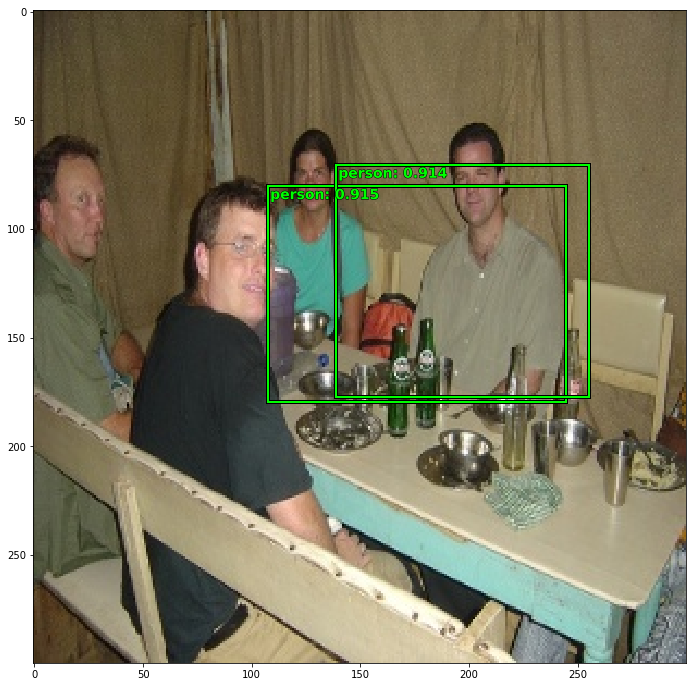

In [277]:
img = denormalize(X[12].permute(1, 2, 0).numpy())
ax = show_img(img, figsize=(12, 12))

for i in range(len(picked_labels)):
    draw_rect(ax, picked_boxes[i])
    text = categories_bb[int(picked_labels.data[i])]
    conf =picked_boxes_probs.data[i]
    draw_text(ax, picked_boxes[i][:2]+1, text+': '+str(round(conf.item(), 3)))

plt.show()

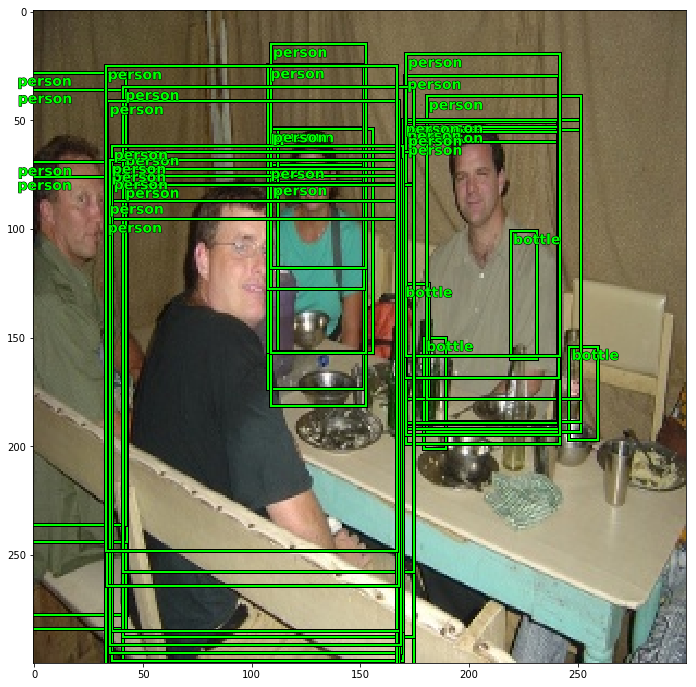

In [278]:
# corresponding training data
idx = 12
img = denormalize(X[idx].permute(1, 2, 0).numpy())
ax = show_img(img, figsize=(12, 12))
i_s = np.where(y_class[idx] != 0)[0]

for i in i_s:
    # center form real box
    bb_real = __boxtools__.convert_locations_to_boxes(y_bb[idx][i].unsqueeze(0).float(), priors,
                                                      center_variance, size_variance)
    box, _ = __boxtools__.to_absolute_coords(img.shape[:2], 
                                             boxes=bb_real[i].reshape(1, -1),
                                             labels=None)
    box = __boxtools__.center_hw(box.squeeze())
    draw_rect(ax, box)
    text = categories_bb[y_class[idx][i].item()]
    draw_text(ax, box[:2]+1, text)

# TODO: add data augmentation